In [1]:
import os
import imageio
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy.linalg import eigh
from sklearn.decomposition import PCA as skl_PCA
from gpflow.config import set_default_float, default_float, set_summary_fmt
import gpflow

from IPython.display import Image, display
import tensorflow as tf

IMG_DIMS = (72, 72, 4)
imshow = lambda flat: plt.imshow(flat.reshape(IMG_DIMS))

def load_faces():
    facedir = 'faces/'
    
    face_arrays = []
    dim = 72 * 72 * 4
    for f in os.listdir(facedir):
        im = imageio.imread(f'{facedir}/{f}')
        face_arrays.append(im.reshape(-1))
    return np.array(face_arrays)

Y = load_faces()
mu = np.mean(Y, axis=0)

In [2]:
np.cov(Y).shape

(88, 88)

In [145]:

# def PCA(Y, k):
#     #1. subtract means
#     dim = Y.shape[1]
#     mu = np.mean(Y, axis=0)
#     residual = Y - mu
    
#     #2. build covariance
#     cov = residual.T @ residual
#     assert dim == cov.shape[1]
    
#     #3. Take leading eigenvectors
#     evals, evecs = eigh(cov, eigvals=(dim-k, dim-1))
#     return evals, evecs

pca = skl_PCA(n_components=3)


In [146]:
pca.fit(Y-mu)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [147]:
print(pca.components_.shape, Y.shape)

(3, 20736) (88, 20736)


In [136]:
y_hat = (((Y-mu) @ pca.components_.T  )@ pca.components_) +mu

In [137]:
emoji=40
imshow(y_hat[emoji].astype(np.int32))

NotImplementedError: It is not currently possible to manually set the aspect on 3D axes

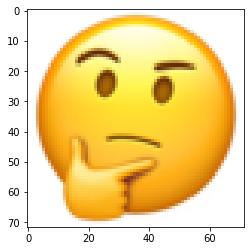

In [8]:
imshow(Y[emoji])

In [139]:
import time
now = time.time()
def gplvm(ydata, x_mean_init):
    latent_dim = x_mean_init.shape[1]

    lengthscale = tf.convert_to_tensor([1.0] * latent_dim, dtype=default_float())
    kernel1 = gpflow.kernels.RBF(lengthscale=lengthscale, ard=True)
    kernel = kernel1

    model = gpflow.models.GPLVM(ydata.astype(np.float64),
                                latent_dim = latent_dim,
                                x_data_mean=x_mean_init,
            kernel=kernel)

    model.likelihood.variance.assign(0.01)

    opt = gpflow.optimizers.Scipy()

    gpflow.utilities.print_summary(model, fmt='notebook')

    # @tf.function(autograph=False)
    def optimization_step():
        return model.neg_log_marginal_likelihood()
   
    _ = opt.minimize(optimization_step, variables=model.trainable_variables, options=dict(maxiter=3000))

    gpflow.utilities.print_summary(model, fmt='notebook')
    return model

modelgp = gplvm(Y, (Y @ pca.components_.T))
print(time.time() - now)

name,class,transform,trainable,shape,dtype,value
GPLVM.kernel.variance,Parameter,Softplus,True,(),float64,1.0
GPLVM.kernel.lengthscale,Parameter,Softplus,True,"(2,)",float64,[1. 1.]
GPLVM.likelihood.variance,Parameter,Softplus,True,(),float64,0.009999999776482648


InvalidArgumentError: Input matrix is not invertible. [Op:MatrixTriangularSolve]

In [129]:
x_data = modelgp.data[0].numpy()

In [130]:
e = [x_data[emoji]]

In [131]:
ypred = modelgp.predict_f(x_data[None, emoji])
ypred = modelgp.predict_f(x_data[None, emoji])

In [132]:
imshow(ypred[0].numpy().astype(int))

NotImplementedError: It is not currently possible to manually set the aspect on 3D axes

In [125]:
%matplotlib notebook

<IPython.core.display.Javascript object>


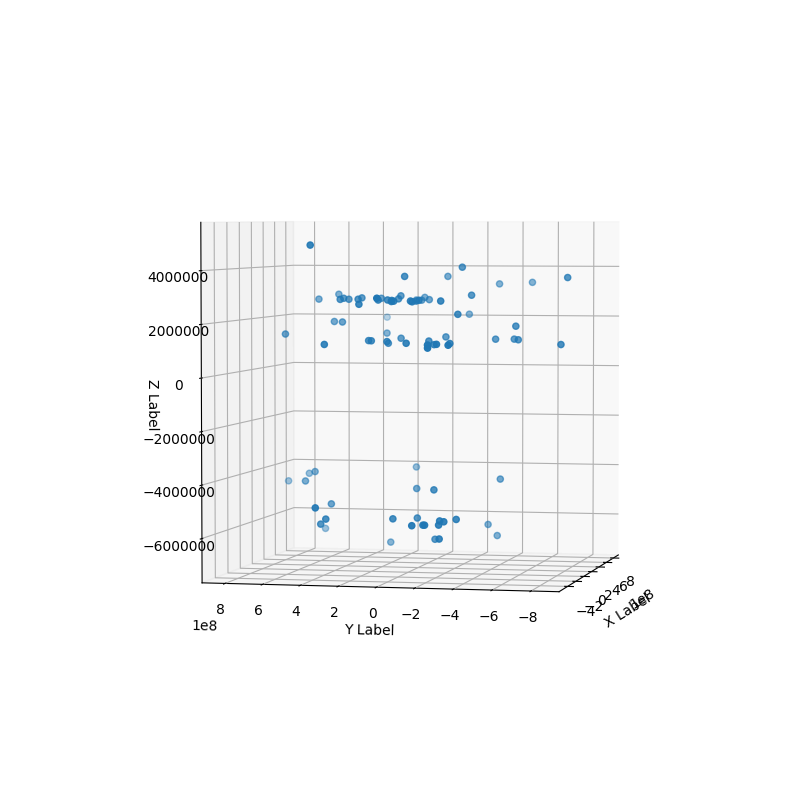

In [126]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
# for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
#     xs = randrange(n, 23, 32)
#     ys = randrange(n, 0, 100)
#     zs = randrange(n, zlow, zhigh)
ax.scatter(x_data[:, 0], x_data[:, 1], x_data[:, 2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [151]:
from gpflow.config import set_default_float, default_float, set_summary_fmt

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt



def fit_gplvm(ydata, x_mean_init):
    latent_dim = x_mean_init.shape[1]
    num_inducing_points = 40
     
    x_var_init = tf.convert_to_tensor(np.ones((ydata.shape[0], latent_dim)), dtype=default_float())

    inducing_variable = tf.convert_to_tensor(np.random.permutation(x_mean_init)[:num_inducing_points], dtype=default_float())
    lengthscale = tf.convert_to_tensor([1.0] * latent_dim, dtype=default_float())
    kernel1 = gpflow.kernels.RBF(lengthscale=lengthscale, ard=True)
    kernel = kernel1

    model = gpflow.models.BayesianGPLVM(ydata.astype(np.float64),
            x_data_mean=tf.convert_to_tensor(x_mean_init),
            x_data_var=x_var_init,
            kernel=kernel,
            inducing_variable=inducing_variable)

    model.likelihood.variance.assign(0.01)

    opt = gpflow.optimizers.Scipy()

    gpflow.utilities.print_summary(model, fmt='notebook')

    # @tf.function(autograph=False)
    def optimization_step():
        return model.neg_log_marginal_likelihood()
   
    _ = opt.minimize(optimization_step, variables=model.trainable_variables, options=dict(maxiter=10000))

    gpflow.utilities.print_summary(model, fmt='notebook')
    return model
mod = fit_gplvm(Y, (Y @ pca.components_.T))


name,class,transform,trainable,shape,dtype,value
BayesianGPLVM.kernel.variance,Parameter,Softplus,True,(),float64,1.0
BayesianGPLVM.kernel.lengthscale,Parameter,Softplus,True,"(3,)",float64,[1. 1. 1.]
BayesianGPLVM.likelihood.variance,Parameter,Softplus,True,(),float64,0.009999999776482648
BayesianGPLVM.x_data_mean,Parameter,,True,"(88, 3)",float64,"[[-14841.60726242, -7568.26504737, -8077.34413961..."
BayesianGPLVM.x_data_var,Parameter,Softplus,True,"(88, 3)",float64,"[[1., 1., 1...."
BayesianGPLVM.inducing_variable.Z,Parameter,,True,"(40, 3)",float64,"[[-17806.85192556, -7902.67033871, -7665.86734925..."


name,class,transform,trainable,shape,dtype,value
BayesianGPLVM.kernel.variance,Parameter,Softplus,True,(),float64,6.927253195985334
BayesianGPLVM.kernel.lengthscale,Parameter,Softplus,True,"(3,)",float64,[0.54913081 0.54601344 0.54646902]
BayesianGPLVM.likelihood.variance,Parameter,Softplus,True,(),float64,0.0231206035968534
BayesianGPLVM.x_data_mean,Parameter,,True,"(88, 3)",float64,"[[-14841.6081161, -7568.26537468, -8077.34448856..."
BayesianGPLVM.x_data_var,Parameter,Softplus,True,"(88, 3)",float64,"[[0.10078447, 0.10075051, 0.10074844..."
BayesianGPLVM.inducing_variable.Z,Parameter,,True,"(40, 3)",float64,"[[-17806.84789813, -7902.66849516, -7665.86556252..."


In [143]:
mod
